### A closer look at who is long-term unemployed

January 3, 2019

@bd_econ

Originally published on the bd econ blog, [here](https://briandew.wordpress.com/2019/01/03/possible-pieces-of-the-long-term-unemployment-puzzle/)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
os.chdir('/home/brian/Documents/CPS/data/clean')

In [2]:
filter_cols = ['AGE', 'LFS', 'BASICWGT', 'UNEMPDUR', 'MONTH', 'EDUC']
component_vars = {'UNEMP': lambda x: 
                  np.where(x['LFS']=='Unemployed', x['BASICWGT'], 0),
                  'LTU': lambda x:
                  np.where((x['LFS']=='Unemployed') & 
                           (x['UNEMPDUR'] > 26), x['BASICWGT'], 0),
                  'LF': lambda x: 
                  np.where(x['LFS'] != 'NILF', x['BASICWGT'], 0)}
unrate = lambda x: (x['UNEMP'] / x['LF']) * 100.0
ltu_sh = lambda x: (x['LTU'] / x['UNEMP']) * 100.0

df = (pd.read_feather('cps2018.ft')
        .filter(filter_cols)
        .query('AGE > 15')
        .assign(**component_vars))

In [3]:
overall = df[['LTU', 'UNEMP']].sum()
total_val = round(overall['LTU'] / overall['UNEMP'] * 100, 1)
total_val

21.4

In [4]:
educ_order = ['LTHS', 'HS', 'SC', 'COLL', 'ADV']
fig1 = (df.groupby('EDUC')[['UNEMP', 'LTU', 'LF']].sum()
          .assign(UNRATE = unrate, LTUSH = ltu_sh)['LTUSH']
          .reindex(educ_order))

In [5]:
names = ['Less than high\nschool degree',
         'High school degree\nor equivalent',
         'Some college or\nassociate degree',
         "Bachelor's degree", 
         'Advanced degree']
fig1.index = names

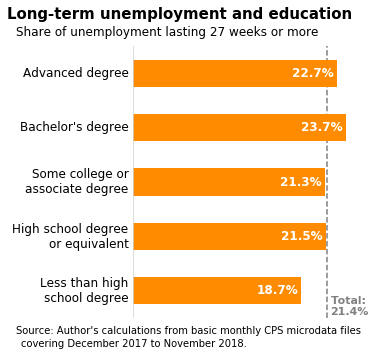

In [6]:
# Figure 1
fig1.plot(kind='barh', color='darkorange', figsize=[4, 5], width=0.5, zorder=2)
for i, val in enumerate(fig1):
    x_val = val - 5
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.06
    plt.text(x_val, y_val, text_val, color='white', fontsize=12, weight='bold')
    plt.text(-0.5, i, fig1.index[i], ha='right', va='center', fontsize=12)
    
plt.axvline(x=21.56, color='gray', linestyle='--', zorder=1)
    
plt.axvline(x=0, color='lightgray')    

# add title and footer
plt.text(-14, 5, 'Long-term unemployment and education', 
          fontsize=15, weight='bold')

plt.text(-13, 4.7, "Share of unemployment lasting 27 weeks or more", 
          fontsize=12)

plt.text(22, -0.45, f"Total:\n{total_val}%", fontsize=11, color='gray', weight='bold')

plt.text(-13, -0.8, "Source: Author's calculations from basic monthly CPS microdata files")
plt.text(-12.5, -1.03, 'covering December 2017 to November 2018.')

plt.axis('off')

plt.savefig('Educ_LTU.png', bbox_inches='tight')
plt.show()

In [7]:
age_groups = np.array_split(np.arange(16, 66, 1), 10)
#age_groups

In [8]:
age_data = pd.Series()
for grp in age_groups:
    result = (df[df['AGE'].isin(grp)][['LTU', 'UNEMP', 'LF']].sum())
    grp_data = round((result['LTU'] / result['UNEMP']) * 100, 1)
    grp_name = f'{grp[0]}-{grp[-1]}'
    age_data.at[grp_name] = grp_data
    age_lf = result['UNEMP'] / result['LF']

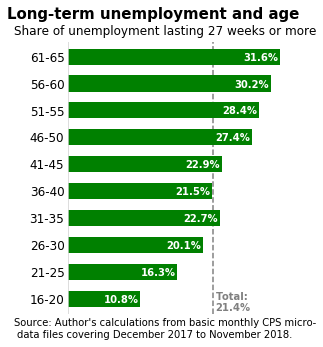

In [9]:
age_data.plot(kind='barh', color='green', figsize=[4, 5], width=0.6, zorder=2)
for i, val in enumerate(age_data):
    x_val = val - 5.5
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.14
    plt.text(x_val, y_val, text_val, color='white', fontsize=10, weight='bold')
    plt.text(-0.5, i-0.05, age_data.index[i], ha='right', va='center', fontsize=12)
# add title and footer
plt.text(-9, 10.4, 'Long-term unemployment and age', 
          fontsize=15, weight='bold')

plt.text(-8, 9.8, "Share of unemployment lasting 27 weeks or more", 
          fontsize=12)

plt.text(22, -0.45, f"Total:\n{total_val}%", fontsize=10, color='gray', weight='bold')

plt.text(-8, -1.0, "Source: Author's calculations from basic monthly CPS micro-")
plt.text(-7.5, -1.45, 'data files covering December 2017 to November 2018.')
plt.axvline(x=21.56, color='gray', linestyle='--', zorder=1)
plt.axvline(x=0, color='lightgray')  
plt.axis('off')

plt.savefig('Age_LTU.png', bbox_inches='tight')
plt.show()

In [10]:
# Base period demographics
def base_period_demographics(df):
    """Function calculates the demographic share each category has and 
       returns age and educ share of the labor force, in a dictionary."""
    df = df[df['LF'] > 0]
    #Calculate each category of age, sex, educ as share of total and store as dict
    aged = (df.groupby('AGE')['BASICWGT'].sum() / df['BASICWGT'].sum()).to_dict()
    educd = (df.groupby('EDUC')['BASICWGT'].sum() / df['BASICWGT'].sum()).to_dict()
    return {'da_age': aged, 'da_educ': educd}

In [11]:
df = (pd.read_feather('cps1998.ft')
        .filter(filter_cols)
        .query('15 < AGE < 80')
        .assign(**component_vars))

In [12]:
dem_adj = base_period_demographics(df)

In [13]:
df = (pd.read_feather('cps2018.ft')
        .filter(filter_cols)
        .query('15 < AGE < 79')
        .assign(**component_vars)
        .query('LF > 0'))

In [14]:
def dem_adjuster(df, dem_adj):
    """Take add month values to df2 for various NILF calculations"""
    # Calculate adjustment value for each demographic adjustment group category
    # Map the adjustment values to the actual people in the CPS
    # AGE
    wgt = df['BASICWGT']
    d1 = (df.groupby('AGE')['BASICWGT'].sum() / df['BASICWGT'].sum()).to_dict()
    agec = {k: dem_adj['da_age'][k]/d1[k] for k in d1.keys() & dem_adj['da_age']}
    age_adj = df['AGE'].map(agec)
    wgt = age_adj * wgt
    # EDUC
    d1 = (df.groupby('EDUC')['BASICWGT'].sum() / df['BASICWGT'].sum()).to_dict()
    educc = {k: dem_adj['da_educ'][k]/d1[k] for k in d1.keys() & dem_adj['da_educ']}    
    educ_adj = df['EDUC'].map(educc)
    wgt = educ_adj * wgt
    df['ADJ_WGT'] = wgt
    df['UNEMP_ADJ'] = np.where(df['UNEMP'] > 0, wgt, 0)
    df['LTU_ADJ'] = np.where(df['LTU'] > 0, wgt, 0)
    
    return df

In [15]:
adj_df = dem_adjuster(df, dem_adj)

In [16]:
overall = adj_df[['LTU_ADJ', 'UNEMP_ADJ']].sum()
total_val = round(overall['LTU_ADJ'] / overall['UNEMP_ADJ'] * 100, 1)
total_val

19.2

In [17]:
df.groupby('EDUC')[['UNEMP', 'LTU', 'LF']].sum().assign(UNRATE = unrate, 
                                                        LTUSH = ltu_sh)

,UNEMP,LTU,LF,UNRATE,LTUSH
EDUC,,,,,
ADV,5164230.0,1170329.50,257471664.0,2.005747,22.662228
COLL,11337936.0,2687896.25,460554176.0,2.461803,23.707104
HS,25316316.0,5435201.50,507937728.0,4.984138,21.469164
LTHS,13625679.0,2550115.50,167357136.0,8.141678,18.715511
SC,20018998.0,4261837.00,540900864.0,3.701048,21.288963
